
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load BEACS module
from beacs.agents.beacs import BEACS, Configuration

# Load Metrics
from example.metrics.MazeMetrics import \
    _maze_metrics, \
    _how_many_peps_match_non_aliased_states, \
    _mean_reliable_classifier_specificity, \
    _when_full_knowledge_is_achieved, \
    _enhanced_effect_error

# Load Plotting Wrappers
from example.metrics.MazePlottingWrapper import \
    parse_metrics_to_df, \
    plot_performance

# Load environments
import gym
import my_mazes

# Agent - BEACS

## Common parameters

In [2]:
#Environmental Set Up
RANDOM_ATTRIBUTE_LENGTH = 0
CLASSIFIER_LENGTH = 8 + RANDOM_ATTRIBUTE_LENGTH
NUMBER_OF_POSSIBLE_ACTIONS = 8
SLIPPERY_PROB = 0.
MAZE = "MazeE2-v0"

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
EPSILON = 0.8

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00
NUMBER_OF_EXPLOIT_TRIALS_RL_START = 500
BETA_EXPLOIT_RL_START = 0.05
NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

#RL Set Up
GAMMA = 0.95
BETA_RL = 0.05

#BEACS Set Up
DO_ZIP = True
DO_GA = True
ENABLE_PEP = True
LENGTH_OF_BEHAVIORAL_SEQUENCES = 2
BETA_ALP = 0.05

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Set up probability to do a random action
maze.env.set_prob_slippery(SLIPPERY_PROB)
# Set up random attribute length
maze.env.set_random_attribute_length(RANDOM_ATTRIBUTE_LENGTH)
# Reset it, by putting an agent into random position
maze.reset()
# Render the state in ASCII
maze.render('aliasing_human')
# Get environmental state transitions
#maze.env.get_theoritical_probabilities()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ A ■ □ □ □ ■ ■ ■
■ ■ ■ □ $ □ ■ ■ ■
■ ■ ■ □ □ □ ■ ■ ■
■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ ■ ■ ■ ■ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BEACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_pep=ENABLE_PEP,
    do_ga=DO_GA,
    beta_alp=BETA_ALP,
    beta_rl=BETA_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BEACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 14min 30s, sys: 1.02 s, total: 14min 31s
Wall time: 14min 32s


### Performance

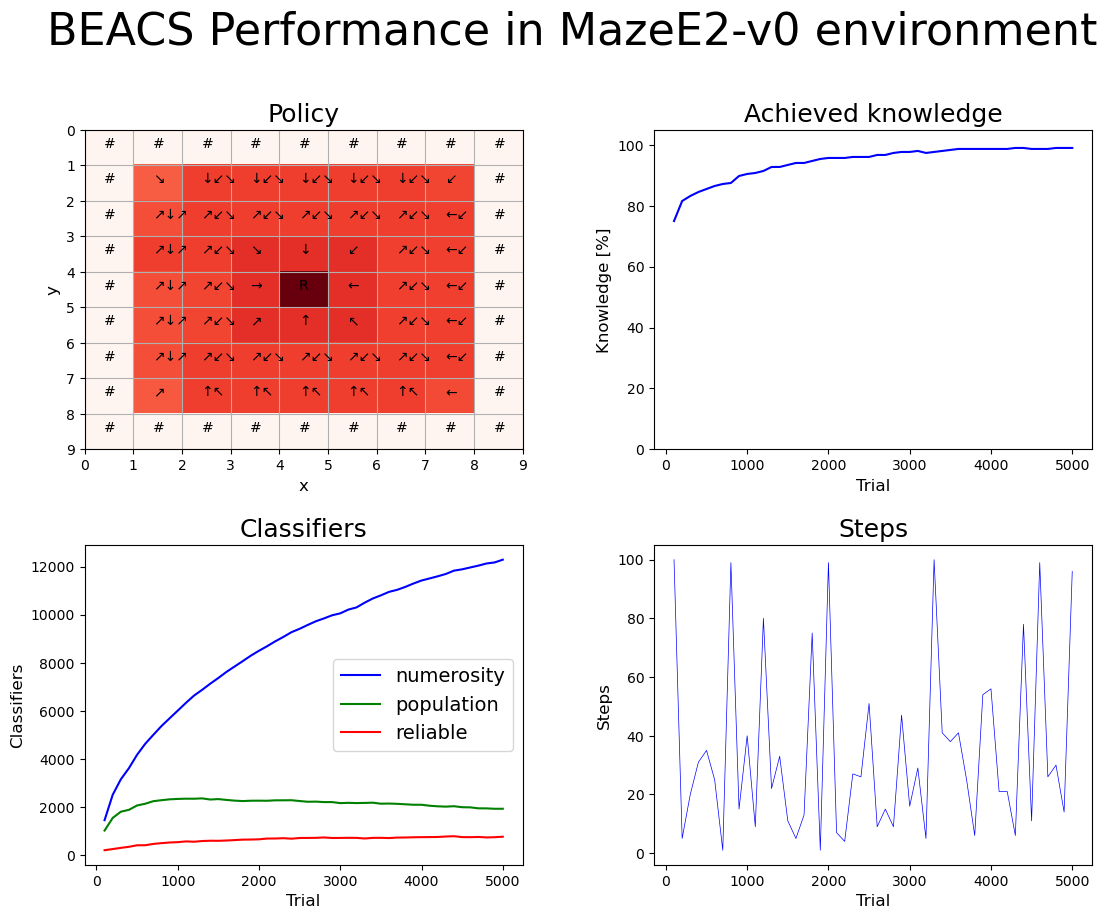

In [5]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, None, None)
plot_performance(agent_explore, maze, metrics_df, cfg_explore, MAZE, metrics_trial_frequency_explore, None)

In [6]:
first_trial, stable_trial, last_trial = _when_full_knowledge_is_achieved(metrics_explore)
print("Full knowledge was achieved at trials ", first_trial, ", was stable at ", stable_trial, 
        " and the last time it was achieved at ", last_trial)

print("There are ", _how_many_peps_match_non_aliased_states(population_explore, maze),
      " enhanced classifer(s) that match a non-aliased states.\n")

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%\n")

if DO_ZIP:
    agent_explore.zip_population()
    population_explore = agent_explore.get_population()

print(_maze_metrics(population_explore, maze))
print("Mean reliable population specifity is ",
      _mean_reliable_classifier_specificity(population_explore, maze))
pep_error = _enhanced_effect_error(population_explore, maze, CLASSIFIER_LENGTH, RANDOM_ATTRIBUTE_LENGTH)
print("Accumulated Error on PEP Probabilities :", pep_error, "%")

Full knowledge was achieved at trials  -1 , was stable at  -1  and the last time it was achieved at  -1
There are  1  enhanced classifer(s) that match a non-aliased states.

{'knowledge': 99.01315789473685, 'population': 1933, 'numerosity': 12285, 'reliable': 771}
Mean reliable population specifity is  0.6819066147859922
Accumulated Error on PEP Probabilities : 0.46201012585921075 %

{'knowledge': 99.01315789473685, 'population': 539, 'numerosity': 6956, 'reliable': 457}
Mean reliable population specifity is  0.5992888402625821
Accumulated Error on PEP Probabilities : 0.45828570442353156 %


In [7]:
population_explore.sort(key=lambda cl: -cl.fitness)
population_explore_to_display = [cl for cl in population_explore]
for cl in population_explore_to_display:
    print(cl)
    print("\n")

#######9 7 None (#######0:#1) (empty)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.0005369
exp: 591   num: 15 ee: False PAI_state: 
tga: 151949 tbseq: 151398 talp: 151949 tav: 268.4  



######9# 6 None (######0#:#1) (empty)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.0005359
exp: 592   num: 14 ee: False PAI_state: 
tga: 152029 tbseq: 152193 talp: 152029 tav: 224.7  



#####9## 5 None (#####0##:#1) (empty)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.01117
exp: 475   num: 20 ee: False PAI_state: 
tga: 152043 tbseq: 151498 talp: 152043 tav: 287.3  



#9###### 1 None (#0######:#1) (empty)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.01577
exp: 460   num: 19 ee: False PAI_state: 
tga: 151986 tbseq: 151251 talp: 151986 tav: 362.2  



##9##### 2 None (##0#####:#1) (empty)
q: 1.0    ra: 1e+03  rb: 1e+03  ir: 1e+03  f: 1e+03  err: 0.02782
exp: 436   num: 17 ee: False PAI_state: 
tga: 151828 tbseq: 151976 talp: 151828 tav: 357.7  



00000000 3 [7, 5] (#######9:#25, ####9###:#11, ######9#:#11, #####111:#45, ########:#14, ###111##:#56, ###9####:#7, #####9##:#13, ###11111:#9) (empty)
q: 1.0    ra: 871.3  rb: 864.0  ir: 0.0    f: 864.0  err: 69.34 
exp: 100   num: 20 ee: False PAI_state: 01110000
tga: 151501 tbseq: 56677 talp: 151501 tav: 1.368e+03 



00000000 4 None (####9###:#30, ###111##:#188, ########:#272, #####9##:#33, ###9####:#18) (empty)
q: 1.0    ra: 862.5  rb: 862.4  ir: 0.0    f: 862.5  err: 31.54 
exp: 507   num: 12 ee: False PAI_state: 
tga: 150661 tbseq: 152213 talp: 150661 tav: 344.5  



11000#01 4 [5] (00###9#0:#26, 00#9###0:#32, 00###11#:#20, 00##9##0:#24, 00#####0:#14) (empty)
q: 0.9997 ra: 870.5  rb: 849.2  ir: 0.0    f: 859.6  err: 81.42 
exp: 73    num: 17 ee: False PAI_state: 00000000
tga: 151133 tbseq: 52042 talp: 151133 tav: 1.814e+03 



00#0011# 1 [4, 1] (###9#000:#24, #9###000:#19, ##9##000:#31, #####000:#15) (00000111)
q: 0.9937 ra: 863.5  rb: 869.4  ir: 0.0    f: 858.1  err: 97.57 
ex

In [8]:
agent_explore.get_pai_states_memory()

[('0', '0', '0', '1', '1', '1', '0', '0'),
 ('0', '0', '0', '0', '0', '1', '1', '1'),
 ('0', '0', '0', '0', '0', '0', '0', '0'),
 ('0', '1', '1', '1', '0', '0', '0', '0'),
 ('1', '1', '0', '0', '0', '0', '0', '1')]

## Training of BEACS - Exploitation

In [9]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_NO_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = BEACS(cfg_exploit_no_rl, population_explore)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)

CPU times: user 1min 51s, sys: 76.5 ms, total: 1min 51s
Wall time: 1min 51s


In [10]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL_START,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = BEACS(cfg_exploit_rl_start, population_exploit_no_rl)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)

CPU times: user 1min 51s, sys: 72.1 ms, total: 1min 51s
Wall time: 1min 51s


In [11]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_pep=ENABLE_PEP,
    do_ga=False,
    beta_alp=BETA_ALP,
    beta_rl=BETA_EXPLOIT_RL,
    gamma=GAMMA,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_bseq=1000,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = BEACS(cfg_exploit_rl, population_exploit_rl_start)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 1min 51s, sys: 78.5 ms, total: 1min 51s
Wall time: 1min 51s


### Performance

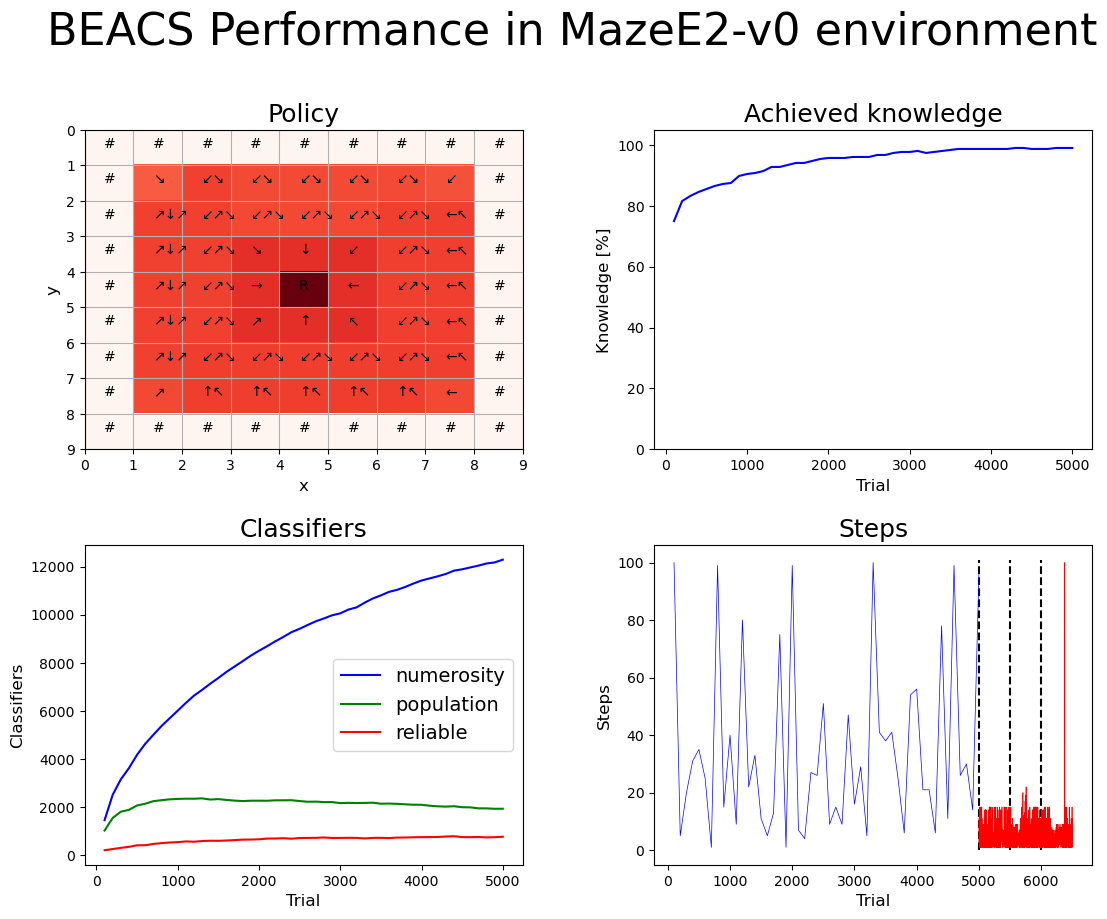

In [12]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])

In [13]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")

print(_maze_metrics(population_explore, maze))
print(_maze_metrics(population_exploit_no_rl, maze))
print(_maze_metrics(population_exploit_rl_start, maze))
print(_maze_metrics(population_exploit_rl, maze))

Average number of steps to solve the maze is  34.54  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  5.458  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  4.912  for a total of  500  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  5.018  for a total of  500  trials in EXPLOITATION with Reinforcement Module
{'knowledge': 99.01315789473685, 'population': 539, 'numerosity': 6956, 'reliable': 457}
{'knowledge': 99.01315789473685, 'population': 539, 'numerosity': 6956, 'reliable': 457}
{'knowledge': 99.01315789473685, 'population': 539, 'numerosity': 6956, 'reliable': 457}
{'knowledge': 99.01315789473685, 'population': 539, 'numerosity': 6956, 'reliable': 457}


In [14]:
population_exploit_rl.sort(key=lambda cl: -cl.exp)
population_exploit_rl_to_display = [cl for cl in population_exploit_rl
    if (cl.behavioral_sequence)]
print(len(population_exploit_rl_to_display))
print("\n")
for cl in population_exploit_rl_to_display:
    print(cl)
    print("\n")

314


00#111#0 0 [7] (###000#9:#402, ###000##:#265, ###00#11:#162, #9#000##:#381, 9##000##:#361) (empty)
q: 1.0    ra: 916.4  rb: 932.3  ir: 0.0    f: 924.3  err: 35.69 
exp: 1547  num: 16 ee: False PAI_state: 00000000
tga: 152233 tbseq: 9690  talp: 152233 tav: 95.13  



01#10000 6 [7] (#000####:#313, 1#00###1:#211, #000#9##:#317, #000##9#:#308, #000###9:#254) (empty)
q: 1.0    ra: 926.1  rb: 911.2  ir: 0.0    f: 918.7  err: 43.16 
exp: 1281  num: 20 ee: False PAI_state: 00000000
tga: 151897 tbseq: 40261 talp: 151912 tav: 109.1  



1#00#001 4 [5, 3] (00####90:#260, 00#####0:#920, 009####0:#292) (empty)
q: 1.0    ra: 866.2  rb: 904.0  ir: 39.29  f: 866.2  err: 95.65 
exp: 767   num: 20 ee: False PAI_state: 00000000
tga: 152065 tbseq: 60651 talp: 152065 tav: 144.4  



01#10##0 6 [5] (#000##9#:#178, #000#9##:#102, #000###9:#189, #00#11##:#146) (01110000)
q: 0.9665 ra: 912.4  rb: 917.2  ir: 0.0    f: 884.2  err: 42.58 
exp: 699   num: 1 ee: True PAI_state: 00000000
tga: 152118 tbseq: 51